In [62]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
from IPython.display import HTML
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict
pd.set_option('display.max_rows', 100)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.weight']= 'bold'


In [63]:
def replace_none(json_dict):
    new_json_dict = dict(json_dict)
    for k, v in json_dict.items():
        if isinstance(v, dict):
            new_json_dict[k] = replace_none(v)
            
        elif v is None:
            new_json_dict[k] = "ignore"
    
    return new_json_dict

In [64]:
def list_json_dir(folder):
    p = Path(folder)

    # list files in dir
    files = [f for f in p.iterdir() if f.suffix == '.json']
    return files

def replace_none(json_dict):
    new_json_dict = dict(json_dict)
    for k, v in json_dict.items():
        if isinstance(v, dict):
            new_json_dict[k] = replace_none(v)
        elif v is None:
            new_json_dict[k] = "ignore"
    
    return new_json_dict

def read_json(f_path):
    with f_path.open('r') as fp:
        json_dict = json.load(fp)
        json_dict["filepath"] = f_path
        json_dict["filename"] = Path(f_path).name

    return replace_none(json_dict)

In [65]:
def pbs_to_params_dir(folder):

    p = Path(folder)

    # list files in dir
    files = [f for f in p.iterdir() if f.suffix == '.pbs']
    pbs_param_dict = {}
    for f in files:
        path_file = p / f
        with path_file.open('r') as fp:
            for line in fp:
                if not line.startswith("python3"):
                    continue
                s = line.replace("python3 reuseSS.py --output ", "")
                result_json_fpath = s.split(" --puzzle ")[0]
                result_json_fpath = result_json_fpath.replace("/data/brussel/101/vsc10143/", "/home/emilio/research/")
                json_fname =    Path(result_json_fpath).name
                pbs_param_dict[json_fname] = str(p / str(f).replace(".pbs", ".json"))

    return pbs_param_dict

In [66]:
def jsonFilesToExtendedDf(jsonFiles, output_folder, param_matching=False):
    """ dictionary hierarchy
        'time' = {
            # number of hitting sets computed
            "totalTime": 0,
            # time spent in hitting set ?
            "hs": [],
            # time spent in optimising hitting set
            "opt": [],
            # time spent in sat
            "sat": [],
            # time spent in grow
            "grow": [],
            # time to find an explanation 
            "explain": [],
            # time propagating information
            "prop": [],
            # time spent in computing a MUS
            "mus":[],
            # time spent in computing a MUS
            "greedyBestStep":[],
            "preprocess":0,
            "preseeding":[],
            "postprocessing":[],
            "timeout": 0,
            "timedout": False
        },
        'numbers' = {
            # number of hitting sets computed
            "hs": [],
            # number of opt calls
            "opt": [],
            # number of sat calls
            "sat": [],
            # number of grow calls
            "grow": [],
            # number of literal explain calls skipped
            "skipped": [],
            # number of calls to propagation
            "prop": 0
        },
        'explanation': [
            'constraints': [], 'derived': [], 'cost': int}
        ]
    """
    if param_matching:
        input_folder = output_folder.replace("output/", "input/")
        pbs_params_dict = pbs_to_params_dir(input_folder)

    pd_dict = defaultdict(list)
    # prepopulate dictionary with good structure

    for f_json in jsonFiles:
        for k,v in f_json.items():
            if not isinstance(v, dict):
                pd_dict[k] = []
                continue

            for ki, vi in v.items():
                k_name = k + "_" + ki
                if k_name not in pd_dict:
                    pd_dict[k_name] = []

    for id, f_json in enumerate(jsonFiles):
        filled_keys = []
        for k,v in f_json.items():
            if not isinstance(v, dict):
                pd_dict[k].append(v)
                filled_keys.append(k)
                continue

            if k == 'time' and not 'timedout' in v:
                pd_dict['time_timedout'].append(True if v["totalTime"] == 7200 else False)
                filled_keys.append('time_timedout')

            for ki, vi in v.items():
                if isinstance(vi, float):
                    vi = round(vi, 2)
                k_name = k + "_" + ki
                pd_dict[k_name].append(vi)
                filled_keys.append(k_name)

        for k in pd_dict:
            if k not in filled_keys:
                pd_dict[k].append("ignore")
    
        if param_matching:
            output_filename = f_json["filename"]
            params_path = pbs_params_dict[output_filename]
            params_f_json = read_json(Path(params_path))

            for k,v in params_f_json.items():
                key_params = "params_" + k
                if key_params not in pd_dict:
                    pd_dict[key_params] = []

                pd_dict[key_params].append(v)

    df = pd.DataFrame(pd_dict)

    return df

def folders_to_df(folders, param_matching=False, n=None):
    df = pd.DataFrame()

    for folder in folders:
        if n:
            files = [read_json(f) for f in list_json_dir(folder)[:n] if f.stat().st_size > 5]
        else:
            files = [read_json(f) for f in list_json_dir(folder) if f.stat().st_size > 5]
        files = [read_json(f) for f in list_json_dir(folder) if f.stat().st_size > 5]
        df_folder = jsonFilesToExtendedDf(files, folder, param_matching)
        df = df.append(df_folder)
    return df

In [67]:

def folder_to_pandas_df_pickle(output_folders, pickle_name="", param_matching=False, n=None):
    path_base_output_dir = "/home/emilio/research/OCUSExplain/experiments/data/output/"
    path_output_dirs = [path_base_output_dir + o for o in output_folders]
    df = folders_to_df(path_output_dirs, param_matching=param_matching, n=n)
    # df.to_pickle(pickle_name)
    return df

def best_puzzle_explanation_computer_config(df_not_timedout):
    df_min_query = df_not_timedout.groupby(["params_instance", "params_explanation_computer"])["time_totalTime"].idxmin()
    df_puzzle_computer = df_not_timedout.loc[df_min_query]

    return df_puzzle_computer

def best_puzzle_config(df_not_timedout):
    df_min_query = df_not_timedout.groupby(["params_instance"])["time_totalTime"].idxmin()
    df_puzzle_computer = df_not_timedout.loc[df_min_query]

    return df_puzzle_computer


In [68]:
def pickle_to_research_questions(pickle_path):
    df = pd.read_pickle(pickle_path)
    all_column_names = ['time_totalTime', 'time_hs', 'time_opt', 'time_sat', 'time_grow', 'time_explain', 'time_prop', 'time_mus', 'time_greedyBestStep', 'time_preprocess', 'time_preseeding', 'time_postprocessing', 'time_timedout', 'numbers_hs', 'numbers_opt', 'numbers_sat', 'numbers_grow', 'numbers_skipped', 'numbers_prop', 'explanation', 'filepath', 'filename', 'params_output', 'params_instance', 'params_timeout', 'params_explanation_computer', 'params_grow', 'params_maxsatpolarity', 'params_interpretation', 'params_weighing', 'params_reuse_SSes', 'params_sort_literals', 'params_filepath', 'params_filename']
    col_inst_time_config = ["params_instance", 'params_explanation_computer', "time_totalTime",'params_grow', 'params_maxsatpolarity', 'params_interpretation', 'params_weighing', 'params_reuse_SSes', 'params_sort_literals']

    # best configuration for all epxlnaation computers
    df_not_timedout = df[(df["time_totalTime"] < 7200) & (df["time_totalTime"] > 0)]

    df_not_timedout_not_MUS = df_not_timedout[df_not_timedout["params_explanation_computer"] != "MUS"]
    df_not_timedout_OCUS = df_not_timedout[df_not_timedout["params_explanation_computer"] == "OCUS"]

    # Best configuration for all explanation computer and all puzzles
    df_best_puzzle_computer_config = best_puzzle_explanation_computer_config(df_not_timedout)[col_inst_time_config]

    # Best configuraiton for all puzzles
    df_best_puzzle_config = best_puzzle_config(df_not_timedout)[col_inst_time_config]
    df_best_puzzle_config_not_MUS = best_puzzle_config(df_not_timedout_not_MUS)[col_inst_time_config]
    df_best_puzzle_config_OCUS = best_puzzle_config(df_not_timedout_OCUS)[col_inst_time_config]

## Applying transformations before plotting 
### 1. Enhancing the data

In [69]:
# ensure totTime is timeout
def cumul_expl_time(row):
    expl_time = row["texpl"]
    cumul_expl = []
    cumul_time = 0
    
    for t in expl_time:
        cumul_time += t
        cumul_expl.append(cumul_time)
    if row["timeout"]:
        cumul_expl.append(row["param_timeout"])
    return cumul_expl

def cumul_lits_derived(row):
    expls = row["explanation"]
    cumul_lits = 0
    cumul_lit_seq = []
    for explanation in expls:
        n_lits_derived = len(explanation["derived"])
        cumul_lits += n_lits_derived
        cumul_lit_seq.append(cumul_lits)
    return cumul_lit_seq

def lits_derived(row):
    expls = row["explanation"]
    lit_seq = []
    for explanation in expls:
        n_lits_derived = len(explanation["derived"])
        lit_seq.append(n_lits_derived)
    return lit_seq

def joint_lits_time(row):
    expls = row["expl_seq"]
    texpl = row["texpl"]
    lit_seq = []
    cumul_time = 0
    for explanation, time_expl  in zip(expls, texpl):
        cumul_time += time_expl
        n_lits_derived = len(explanation["derived"])
        lit_seq.append((cumul_time, n_lits_derived))
    
    if row["timeout"]:
        lit_seq.append((row["param_timeout"], 0))
    return lit_seq

def rename_config(row):
    if row["param_explanation_computer"] == "OCUS":
        if row["param_disableConstrained"]:
            return "OCUS"
        return "OCUS+I"
    elif row["param_explanation_computer"] == "OUS":
        if row["param_reuse_SSes"]:
            return "OUS+I"
        return "OUS"
    elif row["param_explanation_computer"] == "MUS":
        return "MUS"

def rename_grow_config(row):
    grow_renaming = {
        "MAXSAT":"Max",
        'SAT':"Sat", 
        'SUBSET_MAXIMAL':"Greedy-Sat-Full", 
        'SUBSET_MAXIMAL_I0': "Greedy-Sat-Initial", 
        'SUBSET_MAXIMAL_ACTUAL': "Greedy-Sat-Actual", 
        'ignore': "ignore",
        None: "ignore", 
    }
    if row["param_grow"] in ["SUBSET_MAXIMAL", "SUBSET_MAXIMAL_I0", "SUBSET_MAXIMAL_ACTUAL", 'ignore', None, "SAT"]:
        return grow_renaming[row["param_grow"]]

    weights_renaming = {
        'ACTUAL_UNIF': "Actual-Unif",
        'ACTUAL_INV': "Actual-Inv",
        'FULL_POS': "Full-Pos", 
        'FULL_UNIF': "Full-Unif",
        'INITIAL_INV': "Initial-Inv",
        'INITIAL_POS': "Initial-Pos", 
        'ACTUAL_POS': "Actual-Pos",
        'INITIAL_UNIF': "Initial-Unif",
        'FULL_INV':"Full-Inv", 
        'ignore':'ignore', 
        None: "ignore"
    }
    
    return grow_renaming[row["param_grow"]] + "-" + weights_renaming[row["param_weighing"]]

def average_lits_derived_time(row):
    penalty = 7200
    max_lits_puzzle = {
        'origin-problem':150,
         'p12':150,
         'p13':150,
         'p16':150,
         'p18':150,
         'p19':250,
         'p20':150,
         'p25':150,
         'p93':150,
         "frietkot":0,
         "simple":0,
         'pastaPuzzle':96
    }

    avg_lits_derived_times = [(0, 0)]
    j = 1
    tot_time = 0
    for lits_derived, texpl in zip(row["lits_derived"], row["time_explain"]):
        tot_time += texpl
        for i in range(lits_derived):
            avg_lits_derived_times.append((j,tot_time))
            j+= 1

    if row["time_timedout"]:
        tot_time = penalty
        for k in range(j, 251):
            avg_lits_derived_times.append((k, penalty))
        j = max_lits_puzzle[row["params_instance"]]

    elif j< 250:
        for i in range(j, 251):
            avg_lits_derived_times.append((i, tot_time))
            
    return avg_lits_derived_times

def mus_size(expl_seq):
    sizes = []
    for expl in expl_seq:
        size = len(expl["constraints"]) + 1
        sizes.append(size)
    
    return sizes

def cumulative_lits_derived_time(df):
    """Given a specific configuration plot the cumulative explanation time
    with respect to the number of ltierals derived."""
    assert len(set(df["param_explanation_computer"])) == 1, "making sure there is only 1 config"
    assert len(set(df["param_instance"])) == 10, "Making sure we have all puzzles"
    assert len(df) == 10, "Only 10 puzzle configs"
    x = [0]
    y = [0]
    times_lits_derived = []
    
    # one whole list
    for id, row in df.iterrows():
        times_lits_derived += row["joint_lits_time"]

    # sorting on cumulative time
    times_lits_derived.sort(key=lambda x: x[0])
    n_cumul_lits = 0

    # computing the 
    for (t, nlit) in times_lits_derived:
        n_cumul_lits += nlit
        y.append(t)
        x.append(n_cumul_lits)
    
    return x, y

def cumulative_expl_time(df):
    """Given a specific configuration plot the cumulative explanation time
    with respect to the number of ltierals derived."""
    assert len(set(df["param_explanation_computer"])) == 1, "making sure there is only 1 config"
    assert len(set(df["param_instance"])) == 10, "Making sure we have all puzzles"
    assert len(df) == 10, "Only 10 puzzle configs"

    expls_derived = [0]
    
    for id, row in df.iterrows():
        expls_derived += row["cumul_expl"]
    
    expls_derived.sort()
    x = list(range(len(expls_derived)))
    
    return x, expls_derived

def config_cumulative_exec_time(df):
    df_cumul = df.groupby(by=["params_explanation_computer"])["cumul_explain_time"].apply(
        lambda x : sorted(x.sum())
    ).reset_index().rename(columns={'cumul_explain_time':'cumul_explain_time'})
    
    df_cumul["cumul_explain_step"] = df_cumul.apply(
                lambda row: [x for x in range(1, len(row["cumul_explain_time"])+1)]
        , axis=1)

    return df_cumul

def cumulative_mcs_time(row):
    pass

def rename_grow_config(row):
    grow_renaming = {
        "MAXSAT":"Max",
        'SAT':"no-grow", 
        'SUBSETMAX':"Greedy", 
        'ignore': "ignore",
        None: "ignore", 
        '': "ignore",
        "DISJ_MCS": "Disj.MCS-In",
        "DISJ-MCS": "Disj.MCS-In"
    }
    
    base_name = "" +grow_renaming[row["params_grow"]]

    if row["params_grow"] in ["SAT"]:
        return base_name
    if row["params_grow"] in ["DISJ_MCS"]:
        return base_name
    
    inteprretiaon_renaming = {
        "FINAL": "Iend",
        "ACTUAL": "Actual",
        "FULL": "Full",
        "INITIAL": "Init",
        "ignore": ""
    }
    
    weighing_renaming = {
        "UNIFORM": "Unif",
        "POSITIVE": "Pos",
        "INVERSE": "Inv",
        "ignore":""
     }
    if row["params_interpretation"] not in ["","ignore"]:
        base_name +="-" + inteprretiaon_renaming[row["params_interpretation"]]
    if row["params_weighing"] not in ["","ignore"]: 
        base_name +="-" + weighing_renaming[row["params_weighing"]]
    
    return base_name

def rename_explanation_config(row):
    renaming_disj_mcs = {
        "PREPROCESSING_ONLY": "+Disj.MCS once",
        "BOOTSTRAP_ALL":"+Bootstrap Disj. MCS",
        "DISABLED": "",
        None: "",
        "ignore":""
    }
    
    expl_config = row["params_explanation_computer"]
    mcs_config = renaming_disj_mcs[row["params_disjoint_mcses"]]
    grow_config = ("+"+row["params_grow"]) if row["params_grow"] == "DISJ_MCS" else ""
       
    # OPTUX configurations
    if expl_config == "OPTUX_HITMAN" and row["params_disable_disjoint_mcses"] == True:
        return "OptUx"
    elif expl_config == "OPTUX_HITMAN" and row["params_disable_disjoint_mcses"] == False:
        return "OptUx+Disj.MCS-Enum"
    # OCUS configurations
    elif expl_config == "OCUS":
        return "OCUS+Incr. HS"+grow_config+mcs_config
    elif expl_config == "OCUS_NOT_INCREMENTAL":
        return "OCUS"+grow_config+mcs_config
    # OUS configurations
    elif expl_config == "OUS_INCREMENTAL_SHARED":
        return "OUSb+Shared SS. caching"+grow_config+mcs_config
    elif expl_config == "OUS_INCREMENTAL_NAIVE":
        return "OUSb+Lit. Incr. HS"+grow_config+mcs_config
    # OUS Bounded + Satisfiable Subsets
    elif expl_config == "OUS_SS" and row["params_reuse_SSes"] == True:
        return "OUSb+SS. caching"+grow_config+mcs_config
    elif expl_config == "OUS_SS" and row["params_reuse_SSes"] == False:
        return "OUSb"+grow_config+mcs_config
    # OUS Unbounded
    elif expl_config == "OUS_NO_OPT" and row["params_reuse_SSes"]== True:
        return "OUS+SS. caching"+grow_config+mcs_config
    elif expl_config == "OUS_NO_OPT" and row["params_reuse_SSes"]== False:
        print("Here!!!")
        print("OUS"+grow_config+mcs_config)
        return "OUS"+grow_config+mcs_config
    elif expl_config == "OCUS_MCS_ENUM":
        return "OCUS+Mcs.Enum"+grow_config+mcs_config
    # MUS
    elif expl_config == "MUS":
        return "MusX"
    else:
        raise Exception(str(expl_config))

def enhance_dataframe(df):
    df["lits_derived"] = df.apply(lambda row: lits_derived(row), axis=1)
    df["average_lits_derived_time"] = df.apply(lambda row: average_lits_derived_time(row), axis=1)
    df['cumul_explain_time'] = df.apply(
        lambda row: [sum(row["time_explain"][:x]) for x in range(1, len(row["time_explain"])+1)]
    , axis=1)
    df["params_grow_config"] = df.apply(lambda row: rename_grow_config(row), axis=1)
    df["params_explanation_config"] = df.apply(lambda row: rename_explanation_config(row), axis=1)
    
    return df

# Plotting the Data

In [70]:
# all functions for plotting the data
def cactus_plot(df):
    display(df)
    plt.figure(figsize=(20, 12))
    for i, row in df.iterrows():
        x, y, label = row["cumul_explain_step"], row["cumul_explain_time"], row["params_explanation_computer"]
        plt.plot(x, y, label=label.replace('_','-'), linewidth=3)
    plt.legend(loc="upper left", fontsize=20)
    #plt.xscale('log')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("Cumulative $\#$ of explanations",fontsize=28)
    plt.ylabel("Time [s]",fontsize=28)
    plt.title("Log-scaled cumulative explanation-time",fontsize=28)
    plt.grid(True)
    plt.show()


def cactus_plot_derived_lits(df):
    plt.figure(figsize=(20, 12))
    for i, row in df.iterrows():
        x, y, label = row["cumul_explain_step"], row["cumul_explain_time"], row["params_explanation_computer"]
        plt.plot(x, y, label=label.replace('_','-'), linewidth=3)
    plt.legend(loc="upper left", fontsize=20)
    #plt.xscale('log')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("Cumulative $\#$ of literals",fontsize=28)
    plt.ylabel("Time [s]",fontsize=28)
    plt.title("Log-scaled cumulative derived literals time",fontsize=28)
    plt.grid(True)
    #plt.savefig("/home/emilio/research/OCUSExplain/code/pyexplain/benchmark/cactus_derived_lits" +datetime.now().strftime("%Y%m%d%H%M%S%f")+".png")
    plt.show()
    
def round_down(n, z):
    decimals = -1
    multiplier = 10 ** decimals
    return round(math.floor(n * multiplier) / multiplier)

def round_50(n, i=50):
    rounded = (n // i) * i
    return rounded

def heatMapCosts(ousCosts, musCosts, coeff_thick=1, figure_path=None):
    sizes = []
    x = []
    y = []
    for k in ousCosts:
        minlen = min(len(ousCosts[k]), len(musCosts[k]))
        x1 = ousCosts[k]
        y1 = musCosts[k]
        assert len(x1)==len(y1)
        x += x1
        y += y1
    
        d = {}
        for xi,yi in zip(x, y):
            if (xi, yi) in d:
                d[(xi, yi)] += coeff_thick
            else:
                d[(xi, yi)] = coeff_thick

        rounding = round_50
        num = 30
        xmin, xmax = min(x+y), max(x+y)
        all_vals = list(range(rounding(xmin, num), rounding(xmax+num, num), num))
    #     all_vals = list(set(rounding(l,num) for l in x + y))
        all_vals.sort()
        all_valsreversed = list(all_vals)
        all_valsreversed.sort(reverse=True)

        matx = [[0] * len(all_vals) for i in all_vals]


        for ((xi, yi), si) in d.items():

            xpos = all_vals.index(rounding(xi, num))
            ypos = all_valsreversed.index(rounding(yi, num))
            matx[ypos][xpos] = si

    #     fig, ax = plt.subplots()
        fig, ax = plt.subplots(figsize=(5,5))
        im = ax.imshow(matx, cmap='Greys', interpolation='nearest')

        # We want to show all ticks...
        ax.set_xticks(np.arange(len(all_vals)))
        ax.set_yticks(np.arange(len(all_vals)))
        # ... and label them with the respective list entries.
        xticksLabels = [str(val) if idx % 2 == 0 else "" for idx, val in  enumerate(all_vals) ]
        ax.set_xticklabels(xticksLabels,fontsize=16)
        ax.xaxis.label.set_size(16)
        ax.yaxis.label.set_size(16)
        yticksLabels = list(xticksLabels)
        yticksLabels.reverse()
        ax.set_yticklabels(yticksLabels,fontsize=16)

        ax.plot(np.arange(len(all_vals)),range(len(all_vals)-1, -1, -1),linestyle='--')
        fig.tight_layout()
        # plt.xlim((0, 50))d
        plt.xlabel('OUS Explanation cost', fontsize=22)
        plt.ylabel('MUS Explanation cost', fontsize=22)
        vals= [60, 120, 200, 260, 380]
        valsreversed = [60, 120, 200, 260, 380]
        valsreversed.reverse()
        if figure_path:
            plt.savefig(figure_path, bbox_inches='tight')
        plt.show()

def plot_derived_lits_avg_time(d_vals, figure_path=None, figsize=(16, 8), mapping=None,  with_line = False,ordering=None,next_to_graph=False, loc=None):
    #
    ordered_d_vals = list(d_vals.keys())

    if ordering:
        ordered_d_vals = ordering
    
    plt.figure(figsize=figsize)
    if with_line:
        plt.plot(list(range(0, 251,1)), [7200]*251, linewidth=2, color='black', label='Timeout')
    for config in ordered_d_vals:
        if config not in d_vals:
            continue
        timings = d_vals[config]
        x = timings["x"]
        y = timings["y"]
        max_id = 251
        tt = False
#         for id, yi in enumerate(y):
#             if yi < 7180:
#                 max_id +=1
#             elif 7180 <= yi <= 7200 :
#                 tt = True
        label = config.replace('_','-')
        
        if mapping and config in mapping:
            label = mapping[config]

        if label in ["MUS"]:
            plt.plot(x[:max_id], y[:max_id], label=label, linewidth=3, linestyle="--")
            continue
    
        if tt:
            plt.plot(x[:max_id+1], y[:max_id]+[7180], label=label, linewidth=3)
        else:
            plt.plot(x[:max_id], y[:max_id], label=label, linewidth=3)

    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    if next_to_graph:
        plt.legend(fontsize=19, loc='center left', bbox_to_anchor=(1.0, 0.55))
    elif loc:
        plt.legend(loc=loc, fontsize=19)
    else:
        plt.legend(loc="upper left", fontsize=19)

    plt.xlabel("Number of literals derived", fontsize=32)
    plt.ylabel("Avg. cumulative expl time [s]",fontsize=32)
   
    if figure_path:
        print("saving to path=", figure_path)
        plt.savefig(figure_path, bbox_inches='tight')
    
    plt.show()


def cactus_cumulative_lits_derived_time(df, column_name="params_explanation_config", figure_path=None, xlog=True, figsize=(16, 8), mapping=None, ordering=None,next_to_graph=False):
    plt.figure(figsize=figsize)
    
    all_column_values = set(df[column_name])
    
    x = []
    y = []
    max_y = []
    label = []

    if ordering:
        ordering_column_Values = ordering
    else:
        ordering_column_Values = all_column_values

    for id, column_value in enumerate(ordering_column_Values):
        xi, yi = cumulative_lits_derived_time(df[df[column_name] == column_value])
        x.append(xi)
        y.append(yi)
        if mapping:
            label.append(mapping[column_value])
        else:
            label.append(column_value)

        if int(max(yi)) < 7200:
            max_y.append((id, max(yi)))
        else:
            max_y.append((id, max(yi) + 10000 - max(xi)))

    if not ordering:
        max_y.sort(key=lambda xs: xs[1])
    
    for id, _ in max_y:
        plt.plot(x[id], y[id], label=label[id], linewidth=4)
    
    if next_to_graph:
        plt.legend(fontsize=20, loc='center left', bbox_to_anchor=(1.0, 0.5))
    else:
        plt.legend(loc="upper left", fontsize=20)

    if xlog:
        plt.xscale('log')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("Cumulative number of literals derived",fontsize=26)
    plt.ylabel("Time [s]",fontsize=24)
    # plt.title("Cumulative Literals derived time",fontsize=28)
    plt.grid(True)
    if figure_path:
        plt.savefig(figure_path, bbox_inches='tight')
    plt.show()

def cactus_cumulative_expl_time(df, column_name="params_explanation_config", figure_path=None, xlog=True, figsize=(16, 8), mapping=None, ordering=None,next_to_graph=False):
    plt.figure(figsize=figsize)
    
    all_column_values = set(df[column_name])
    x = []
    y = []
    max_y = []
    label = []

    
    if ordering:
        ordering_column_Values = ordering
    else:
        ordering_column_Values = all_column_values
        
    for id, column_value in enumerate(ordering_column_Values):
        xi, yi = cumulative_expl_time(df[df[column_name] == column_value])
        x.append(xi)
        y.append(yi)
        if mapping:
            label.append(mapping[column_value])
        else:
            label.append(column_value)
        
        if int(max(yi)) < 7200:
            max_y.append((id, max(yi)))
        else:
            max_y.append((id, max(yi) + 10000 - max(xi)))
    if not ordering:
        max_y.sort(key=lambda xs: xs[1])
    
    
    for id, my in max_y:
        plt.plot(x[id], y[id], label=label[id], linewidth=4)
    
    if next_to_graph:
        plt.legend(fontsize=20, loc='center left', bbox_to_anchor=(1.0, 0.5))
    else:
        plt.legend(loc="upper left", fontsize=20)

    if xlog:
        plt.xscale('log')
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.xlabel("Cumulative number of Explanation steps",fontsize=28)
    plt.ylabel("Time [s]",fontsize=28)
    # plt.title("Cumulative explanation-time",fontsize=28)
    plt.grid(True)
    if figure_path:
        plt.savefig(figure_path, bbox_inches='tight')
    plt.show()
    

In [71]:
def summarize_cumalitve_lits_derived_time(df_rq, column_name, ignored):
    # dict with cumulative times
    d_cumul_avg_time_incr = {
        config: {"x":None, "y": None} for config in set(df_rq[column_name]) if config not in ignored
    }

    for config in set(df_rq[column_name]):
        if config in ignored:
            continue
        t_ordered = []
        # make it 1 graph
        for id, row in df_rq[df_rq[column_name]==config].iterrows():
            t_ordered+=row["average_lits_derived_time"]
        t_ordered.sort(key=lambda l: l[0])

        d_ordered = defaultdict(float)
        d_n_ordered = defaultdict(int)
        for step, ti in t_ordered:
            d_ordered[step] += ti
            d_n_ordered[step] += 1

        for step in d_ordered:
            d_ordered[step] /= d_n_ordered[step] 
        x=[]
        y=[]
        for step in sorted(d_ordered):
            x.append(step)
            y.append(d_ordered[step])

        d_cumul_avg_time_incr[config] = {"x": x, "y":y}
    ordering = [config for config in sorted(d_cumul_avg_time_incr,key= lambda config: d_cumul_avg_time_incr[config]["y"][-1])]
    ordering.reverse()
        
    return d_cumul_avg_time_incr, ordering
# display(df_rq34)

# Importing Data from folder

In [72]:
PATH_OCUS_EXPLAIN = Path("/home/emilio/research/OCUSExplain/")
PATH_POST_PAPER= PATH_OCUS_EXPLAIN / "conferences/2021_IJCAI/results/post_paper/output/" 
PATH_POST_PAPER_RESULTS = PATH_POST_PAPER / "2021050517/"
PATH_COSTS_RESUTS = PATH_POST_PAPER / "costs/"
PATH_FIGURES_POST_PAPER = Path("/home/emilio/research/holygrail/latex/conferences/ijcai21/paper/figures_post_paper/")

In [73]:
#  Optux Previsou results = 2021061714
# 
output_folders = ["2021071916/"]
pickle_name ="pickles/2021071916.pkl"

path_base_output_dir = "/home/emilio/research/OCUSExplain/experiments/data/output/"
path_output_dirs = [path_base_output_dir + o for o in output_folders]
df = folder_to_pandas_df_pickle(output_folders, pickle_name, False)


In [74]:
print(df.columns.to_list())


['time_totalTime', 'time_timeout', 'time_timedout', 'time_explain', 'time_cumul_explain', 'time_prop', 'time_opt', 'time_sat', 'time_grow', 'time_disj_mcs', 'time_preseeding', 'numbers_prop', 'numbers_explained', 'numbers_opt', 'numbers_sat', 'numbers_grow', 'numbers_hs', 'numbers_disj_mcs', 'explanation', 'params_output', 'params_instance', 'params_timeout', 'params_explanation_computer', 'params_grow', 'params_maxsatpolarity', 'params_interpretation', 'params_weighing', 'params_reuse_SSes', 'params_sort_literals', 'params_disable_disjoint_mcses', 'params_disjoint_mcses', 'params_disjoint_mcs_interpretation', 'params_disjoint_mcs_weighing', 'filepath', 'filename', 'time_tavg_greedy_explain', 'numbers_skipped', 'time_postprocessing', 'numbers_SSes_before', 'numbers_SSes_after']


In [75]:
df = enhance_dataframe(df)

In [76]:
set(df["params_explanation_config"])

{'MusX',
 'OCUS',
 'OCUS+Bootstrap Disj. MCS',
 'OCUS+DISJ_MCS',
 'OCUS+DISJ_MCS+Bootstrap Disj. MCS',
 'OCUS+DISJ_MCS+Disj.MCS once',
 'OCUS+Disj.MCS once',
 'OCUS+Incr. HS',
 'OCUS+Incr. HS+Bootstrap Disj. MCS',
 'OCUS+Incr. HS+DISJ_MCS',
 'OCUS+Incr. HS+DISJ_MCS+Bootstrap Disj. MCS',
 'OCUS+Incr. HS+DISJ_MCS+Disj.MCS once',
 'OCUS+Incr. HS+Disj.MCS once',
 'OCUS+Mcs.Enum',
 'OCUS+Mcs.Enum+Bootstrap Disj. MCS',
 'OCUS+Mcs.Enum+DISJ_MCS',
 'OCUS+Mcs.Enum+DISJ_MCS+Bootstrap Disj. MCS',
 'OCUS+Mcs.Enum+DISJ_MCS+Disj.MCS once',
 'OCUS+Mcs.Enum+Disj.MCS once',
 'OUS+SS. caching',
 'OUS+SS. caching+Bootstrap Disj. MCS',
 'OUS+SS. caching+DISJ_MCS',
 'OUS+SS. caching+DISJ_MCS+Bootstrap Disj. MCS',
 'OUS+SS. caching+DISJ_MCS+Disj.MCS once',
 'OUS+SS. caching+Disj.MCS once',
 'OUSb',
 'OUSb+Bootstrap Disj. MCS',
 'OUSb+DISJ_MCS',
 'OUSb+DISJ_MCS+Bootstrap Disj. MCS',
 'OUSb+DISJ_MCS+Disj.MCS once',
 'OUSb+Disj.MCS once',
 'OUSb+Lit. Incr. HS',
 'OUSb+Lit. Incr. HS+Bootstrap Disj. MCS',
 'OUSb

In [77]:
df[df["params_explanation_computer"]  == "OUS_NO_OPT"][[
    'time_totalTime',
     'params_instance',
    'params_explanation_config',
     'params_maxsatpolarity',
    'params_grow_config',
     'params_reuse_SSes',
     'params_sort_literals',
     'params_disable_disjoint_mcses',
     'lits_derived',
     'average_lits_derived_time',
     'cumul_explain_time'
]]

,time_totalTime,params_instance,params_explanation_config,params_maxsatpolarity,params_grow_config,params_reuse_SSes,params_sort_literals,params_disable_disjoint_mcses,lits_derived,average_lits_derived_time,cumul_explain_time
9,0.0,p13,OUS+SS. caching+Bootstrap Disj. MCS,True,Max-Actual-Unif,True,False,ignore,[],"[(0, 0), (1, 7200), (2, 7200), (3, 7200), (4, ...",[]
23,0.0,p19,OUS+SS. caching,True,Max-Actual-Unif,True,False,ignore,[],"[(0, 0), (1, 7200), (2, 7200), (3, 7200), (4, ...",[]
52,0.0,p25,OUS+SS. caching,True,Max-Actual-Unif,True,False,ignore,[],"[(0, 0), (1, 7200), (2, 7200), (3, 7200), (4, ...",[]
58,0.0,p93,OUS+SS. caching+Bootstrap Disj. MCS,True,Max-Actual-Unif,True,False,ignore,[],"[(0, 0), (1, 7200), (2, 7200), (3, 7200), (4, ...",[]
59,0.0,simple,OUS+SS. caching+Disj.MCS once,True,Max-Actual-Unif,True,False,ignore,[],"[(0, 0), (1, 7200), (2, 7200), (3, 7200), (4, ...",[]
60,0.0,p93,OUS+SS. caching+DISJ_MCS+Bootstrap Disj. MCS,True,Disj.MCS-In,True,False,ignore,[],"[(0, 0), (1, 7200), (2, 7200), (3, 7200), (4, ...",[]
63,0.0,p12,OUS+SS. caching+Bootstrap Disj. MCS,True,Max-Actual-Unif,True,False,ignore,[],"[(0, 0), (1, 7200), (2, 7200), (3, 7200), (4, ...",[]
64,0.0,p19,OUS+SS. caching+Disj.MCS once,True,Max-Actual-Unif,True,False,ignore,[],"[(0, 0), (1, 7200), (2, 7200), (3, 7200), (4, ...",[]
77,0.0,frietkot,OUS+SS. caching+Disj.MCS once,True,Max-Actual-Unif,True,False,ignore,[],"[(0, 0), (1, 7200), (2, 7200), (3, 7200), (4, ...",[]
87,0.0,p25,OUS+SS. caching+Disj.MCS once,True,Max-Actual-Unif,True,False,ignore,[],"[(0, 0), (1, 7200), (2, 7200), (3, 7200), (4, ...",[]


In [78]:
mus_configs =  [config for config in set(df["params_explanation_config"]) if "MUS" in config.upper()]
print("MUS configs\n",mus_configs,"\n")

MUS configs
 ['MusX'] 



In [79]:
selected_columns = [
    'time_totalTime',
     'params_instance',
    'params_explanation_config',
     'params_maxsatpolarity',
    'params_grow_config',
     'params_reuse_SSes',
     'params_sort_literals',
     'params_disable_disjoint_mcses',
     'lits_derived',
     'average_lits_derived_time',
     'cumul_explain_time'
]
df_enhanced = df[selected_columns]

In [80]:
df[df["params_explanation_config"] == "OCUS"][
    ["params_instance"] + ["numbers_hs"]]

,params_instance,numbers_hs
13,simple,"[4, 5, 2]"
15,p12,"[40, 41, 52, 33, 32, 47, 27, 28, 33, 66, 20, 5..."
39,p19,"[0, 40, 45, 75, 26, 56, 28, 75, 59, 32, 64, 69..."
118,pastaPuzzle,"[25, 34, 40, 43, 35, 40, 24, 24, 21, 14, 36, 4..."
148,p25,"[47, 72, 59, 62, 69, 68, 73, 37, 26, 75, 73, 3..."
229,p20,"[50, 46, 56, 34, 31, 61, 33, 31, 34, 74, 43, 4..."
277,p18,"[49, 63, 38, 43, 47, 29, 29, 28, 55, 39, 43, 4..."
281,p16,"[63, 37, 34, 52, 33, 35, 28, 71, 58, 68, 76, 7..."
293,origin-problem,"[50, 37, 47, 56, 35, 37, 31, 30, 46, 51, 31, 5..."
308,p93,"[52, 43, 52, 33, 32, 31, 65, 35, 72, 40, 43, 3..."


In [81]:
df[df["params_explanation_config"] == "OCUS+DISJ_MCS+Disj.MCS all"][
    ["params_instance"] + ["numbers_disj_mcs", "numbers_hs"]
]

,params_instance,numbers_disj_mcs,numbers_hs


In [82]:
df[df["params_explanation_config"] == "OCUS+DISJ_MCS"][
    ["params_instance"] + ["numbers_disj_mcs", "numbers_hs"]
]


,params_instance,numbers_disj_mcs,numbers_hs
5,pastaPuzzle,"[25, 34, 40, 52, 35, 40, 24, 24, 21, 14, 36, 4...","[25, 34, 40, 52, 35, 40, 24, 24, 21, 14, 36, 4..."
122,p18,"[49, 63, 38, 43, 47, 29, 29, 28, 55, 39, 44, 4...","[49, 63, 38, 43, 47, 29, 29, 28, 55, 39, 44, 4..."
126,p16,"[63, 37, 34, 52, 33, 35, 28, 71, 58, 68, 76, 7...","[63, 37, 34, 52, 33, 35, 28, 71, 58, 68, 76, 7..."
163,p20,"[50, 46, 56, 34, 31, 61, 33, 31, 34, 68, 43, 4...","[50, 46, 56, 34, 31, 61, 33, 31, 34, 68, 43, 4..."
175,p19,"[0, 40, 44, 75, 26, 56, 28, 75, 52, 32, 64, 69...","[0, 40, 44, 75, 26, 56, 28, 75, 52, 32, 64, 69..."
270,simple,"[4, 5, 2]","[4, 5, 2]"
273,p93,"[52, 43, 52, 33, 32, 31, 65, 35, 72, 40, 43, 3...","[52, 43, 52, 33, 32, 31, 65, 35, 72, 40, 43, 3..."
322,origin-problem,"[50, 37, 47, 56, 35, 37, 31, 30, 47, 51, 31, 5...","[50, 37, 47, 56, 35, 37, 31, 30, 47, 51, 31, 5..."
324,p12,"[40, 41, 52, 33, 32, 47, 27, 28, 32, 66, 20, 5...","[40, 41, 52, 33, 32, 47, 27, 28, 32, 66, 20, 5..."
372,p25,"[47, 72, 59, 62, 69, 68, 73, 37, 26, 49, 73, 3...","[47, 72, 59, 62, 69, 68, 73, 37, 26, 49, 73, 3..."


saving to path= /home/emilio/research/OCUSExplain/presentations/Ignatiev/figures/2021_07_23_presentation_configs.pdf


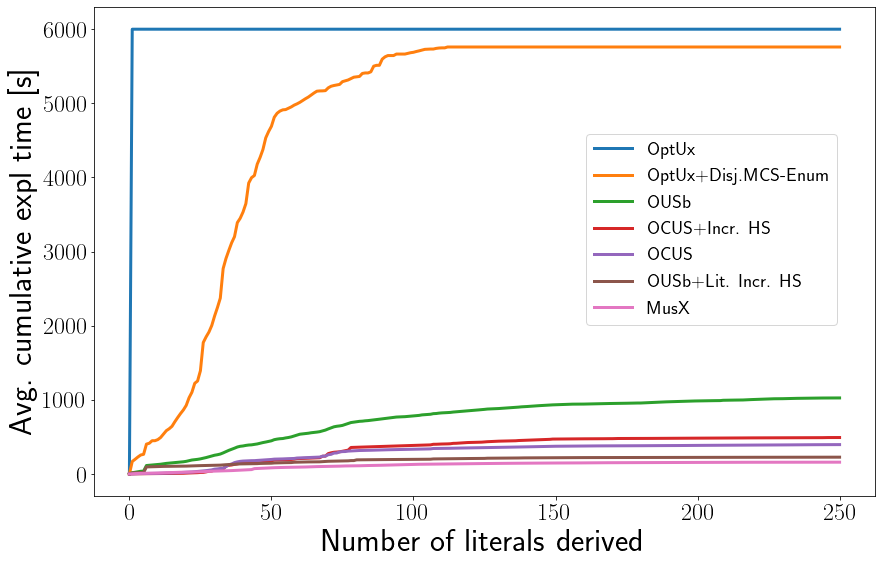

In [102]:
presentation_configs= ["OCUS", "OCUS+Incr. HS", "OUSb+Lit. Incr. HS", "OUSb", "OUS", "OptUx","OptUx+Disj.MCS-Enum", "MusX"]
df_presentation = df_enhanced[
    df_enhanced["params_explanation_config"].isin(presentation_configs)
]

d_cumul_avg_time_incr, ordering = summarize_cumalitve_lits_derived_time(df_presentation, "params_explanation_config",[])

plot_derived_lits_avg_time(
    d_cumul_avg_time_incr, 
     ordering=ordering,
    figsize=(14, 9), 
    with_line = False,
    loc=(0.63, 0.35),
    #next_to_graph=True,
    figure_path="/home/emilio/research/OCUSExplain/presentations/Ignatiev/figures/2021_07_23_presentation_configs.pdf",
)


# Summary Tables

saving to path= /home/emilio/research/OCUSExplain/meetings/2021/presentations/2021_07_16_optux_disj_mcs_enum.pdf


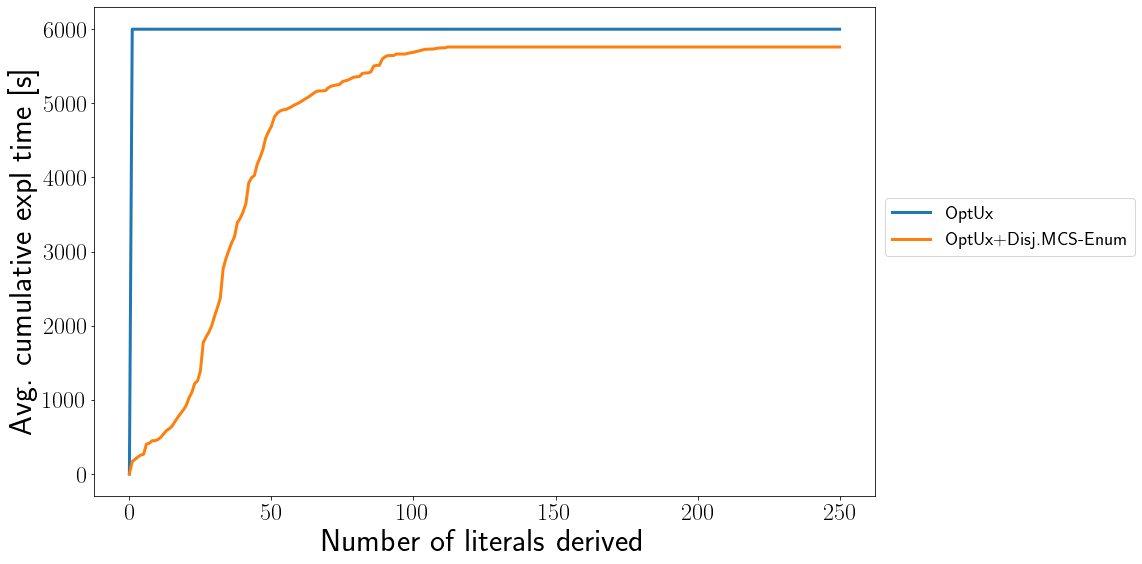

In [84]:
df_optux = df_enhanced[
    df_enhanced["params_explanation_config"].isin(['OptUx', 'OptUx+Disj.MCS-Enum'])
]

df_optux.to_excel('/home/emilio/research/OCUSExplain/meetings/2021/presentations/optux.xlsx', index = False)

d_cumul_avg_time_incr, ordering = summarize_cumalitve_lits_derived_time(df_optux, "params_explanation_config",[])

plot_derived_lits_avg_time(
    d_cumul_avg_time_incr, 
     ordering=ordering,
    figsize=(14, 9), 
    with_line = False,
    next_to_graph=True,
    figure_path="/home/emilio/research/OCUSExplain/meetings/2021/presentations/2021_07_16_optux_disj_mcs_enum.pdf",
)


In [85]:
isntances = [
    #'simple',
    'p25',
    'p16',
    'origin-problem',
    'pastaPuzzle',
    'p20',
    'p19',
    'p18',
    'p93',
    'p13',
#    'frietkot',
    'p12']

['OCUS+Mcs.Enum+Disj.MCS once', 'OCUS+Mcs.Enum+DISJ_MCS+Bootstrap Disj. MCS', 'OCUS+Mcs.Enum', 'OCUS+Mcs.Enum+Bootstrap Disj. MCS', 'OCUS+Mcs.Enum+DISJ_MCS+Disj.MCS once', 'OCUS+Mcs.Enum+DISJ_MCS']
saving to path= /home/emilio/research/OCUSExplain/meetings/2021/presentations/2021_07_22_ocus_disj_mcs_enum.pdf


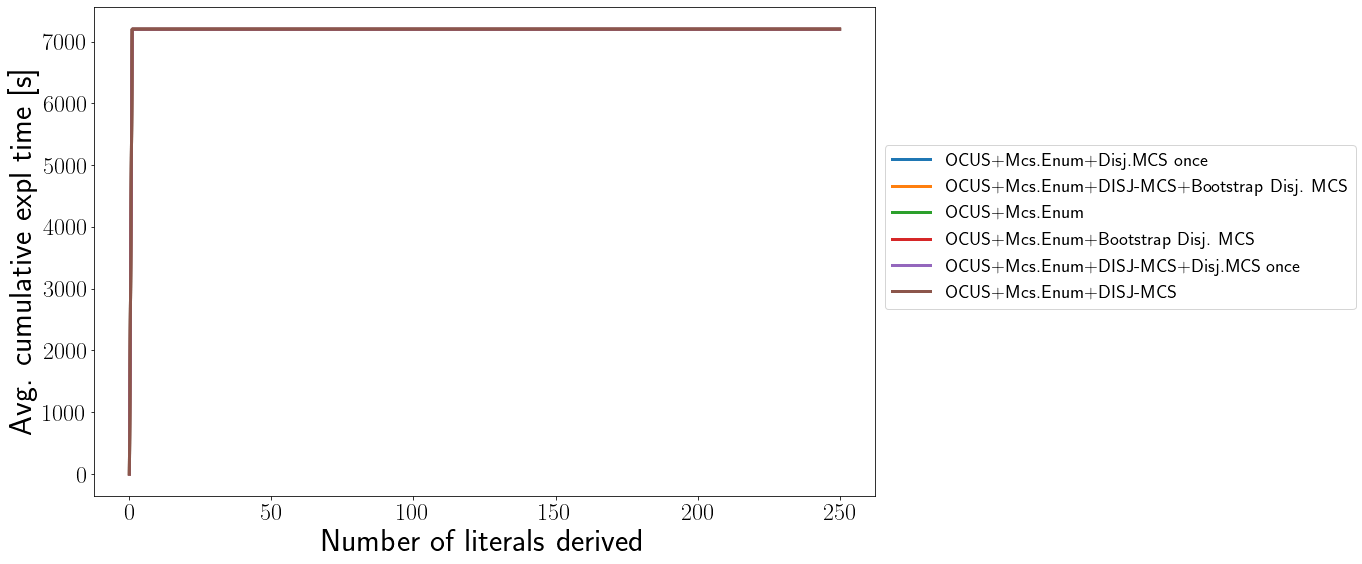

In [86]:
ocus_mcs_configs = [config for config in set(df["params_explanation_config"]) if "OCUS+Mcs.Enum" in config]

ignored_ocus = []

df_ocus_mcs = df[
    df["params_explanation_config"].isin(ocus_mcs_configs)
]

df_ocus_mcs.to_excel('/home/emilio/research/OCUSExplain/meetings/2021/presentations/ocus_mcs.xlsx', index = False)

df_ocus_mcs_enum = df_enhanced[
    df_enhanced["params_explanation_config"].isin(ocus_mcs_configs) & 
    df_enhanced["params_instance"].isin(isntances)
]
# display(df_ocus_mcs_enum)
d_cumul_avg_time_incr, ordering = summarize_cumalitve_lits_derived_time(df_ocus_mcs_enum, "params_explanation_config",ignored_ocus)
print(ordering)

plot_derived_lits_avg_time(
    d_cumul_avg_time_incr, 
    ordering=ordering,
    figsize=(14, 9), 
    with_line = False,
    next_to_graph=True,
    figure_path="/home/emilio/research/OCUSExplain/meetings/2021/presentations/2021_07_22_ocus_disj_mcs_enum.pdf",
)

['OCUS', 'OCUS+DISJ_MCS', 'OCUS+DISJ_MCS+Bootstrap Disj. MCS', 'OCUS+Bootstrap Disj. MCS']
saving to path= /home/emilio/research/OCUSExplain/presentations/Ignatiev/figures/ocus_disj_mcs.pdf


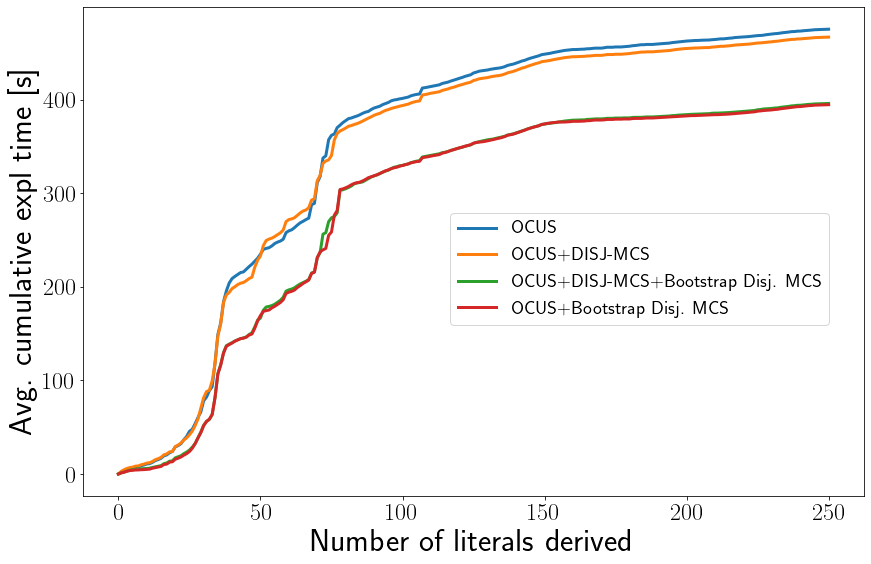

In [117]:
ocus_not_incr_configs = [
    config for config in set(df["params_explanation_config"]) if "OCUS" in config.upper() and config not in ocus_mcs_configs and "Incr. HS" not in config
]

ignored_ocus = ["OCUS+DISJ_MCS+Disj.MCS once", 'OCUS+Disj.MCS once']

df_ocus_not_incr = df[
    df["params_explanation_config"].isin(ocus_not_incr_configs)
]
df_ocus_not_incr.to_excel('/home/emilio/research/OCUSExplain/meetings/2021/presentations/2021_07_22_ocus_not_incr.xlsx', index = False)

df_ocus_not_incr_mcs_enum = df_enhanced[
    df_enhanced["params_explanation_config"].isin(ocus_not_incr_configs) & 
    df_enhanced["params_instance"].isin(isntances)
]
# display(df_ocus_mcs_enum)
d_cumul_avg_time_incr, ordering = summarize_cumalitve_lits_derived_time(df_ocus_not_incr_mcs_enum, "params_explanation_config",ignored_ocus)
print(ordering)

plot_derived_lits_avg_time(
    d_cumul_avg_time_incr, 
    ordering=ordering,
    figsize=(14, 9), 
    with_line = False,
    loc=(0.47, 0.35),
    figure_path="/home/emilio/research/OCUSExplain/presentations/Ignatiev/figures/ocus_disj_mcs.pdf",
)


['OCUS+Incr. HS', 'OCUS+Incr. HS+DISJ_MCS+Disj.MCS once', 'OCUS+Incr. HS+Disj.MCS once', 'OCUS+Incr. HS+DISJ_MCS', 'OCUS+Incr. HS+Bootstrap Disj. MCS', 'OCUS+Incr. HS+DISJ_MCS+Bootstrap Disj. MCS']
saving to path= /home/emilio/research/OCUSExplain/presentations/Ignatiev/figures/ocus_incr_disj_mcses.pdf


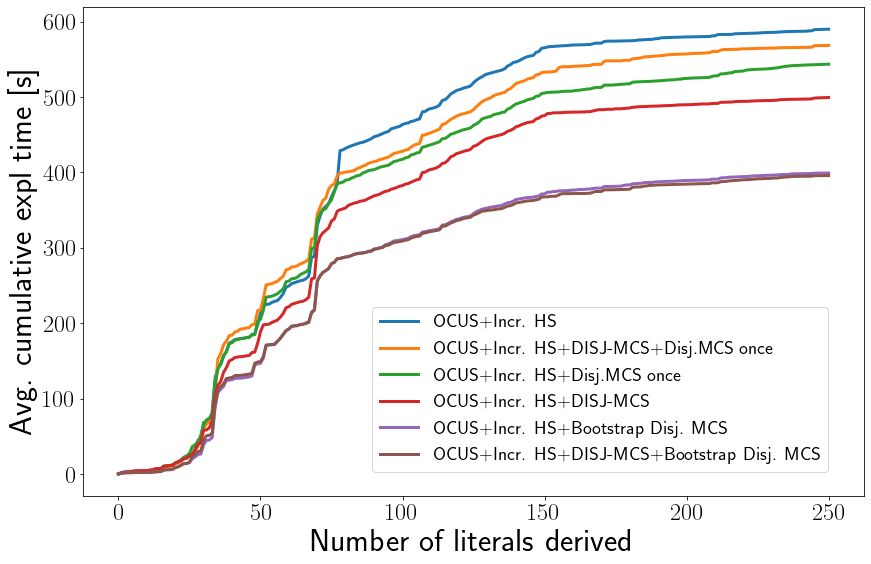

In [120]:
ocus_incr_configs = [
    config for config in set(df["params_explanation_config"]) if "OCUS" in config.upper() and config not in ocus_mcs_configs  and "Incr. HS" in config
]

ignored_ocus = []

df_ocus_incr = df[
    df["params_explanation_config"].isin(ocus_incr_configs)
]
df_ocus_incr.to_excel('/home/emilio/research/OCUSExplain/meetings/2021/presentations/ocus_2.xlsx', index = False)

df_ocus_incr_mcs_enum = df_enhanced[
    df_enhanced["params_explanation_config"].isin(ocus_incr_configs) & 
    df_enhanced["params_instance"].isin(isntances)
]

# display(df_ocus_mcs_enum)
d_cumul_avg_time_incr, ordering = summarize_cumalitve_lits_derived_time(df_ocus_incr_mcs_enum, "params_explanation_config",[])
print(ordering)

plot_derived_lits_avg_time(
    d_cumul_avg_time_incr, 
    ordering=ordering,
    figsize=(14, 9), 
    with_line = False,
    loc=(0.37, 0.05),
    figure_path="/home/emilio/research/OCUSExplain/presentations/Ignatiev/figures/ocus_incr_disj_mcses.pdf",
)

In [89]:
#display(df_ocus_mcs_enum[["params_explanation_config","params_instance", "time_totalTime"]].sort_values(by=["params_instance",'params_explanation_config']))


['OUSb+Lit. Incr. HS+DISJ_MCS+Disj.MCS once', 'OUSb+Lit. Incr. HS', 'OUSb+DISJ_MCS', 'OUSb+Lit. Incr. HS+Disj.MCS once', 'OUSb+DISJ_MCS+Bootstrap Disj. MCS', 'OUSb+DISJ_MCS+Disj.MCS once', 'OUSb+Shared SS. caching+Bootstrap Disj. MCS', 'OUSb+Shared SS. caching+DISJ_MCS+Disj.MCS once', 'OUSb+Lit. Incr. HS+DISJ_MCS', 'OUSb+Shared SS. caching', 'OUSb+Shared SS. caching+DISJ_MCS', 'OUSb+Shared SS. caching+DISJ_MCS+Bootstrap Disj. MCS', 'OUSb+Lit. Incr. HS+Bootstrap Disj. MCS', 'OUSb', 'OUSb+Shared SS. caching+Disj.MCS once', 'OUSb+Lit. Incr. HS+DISJ_MCS+Bootstrap Disj. MCS', 'OUSb+Disj.MCS once', 'OUSb+Bootstrap Disj. MCS']
saving to path= /home/emilio/research/OCUSExplain/meetings/2021/presentations/2021_07_22_ousb_disj_mcs_enum.pdf


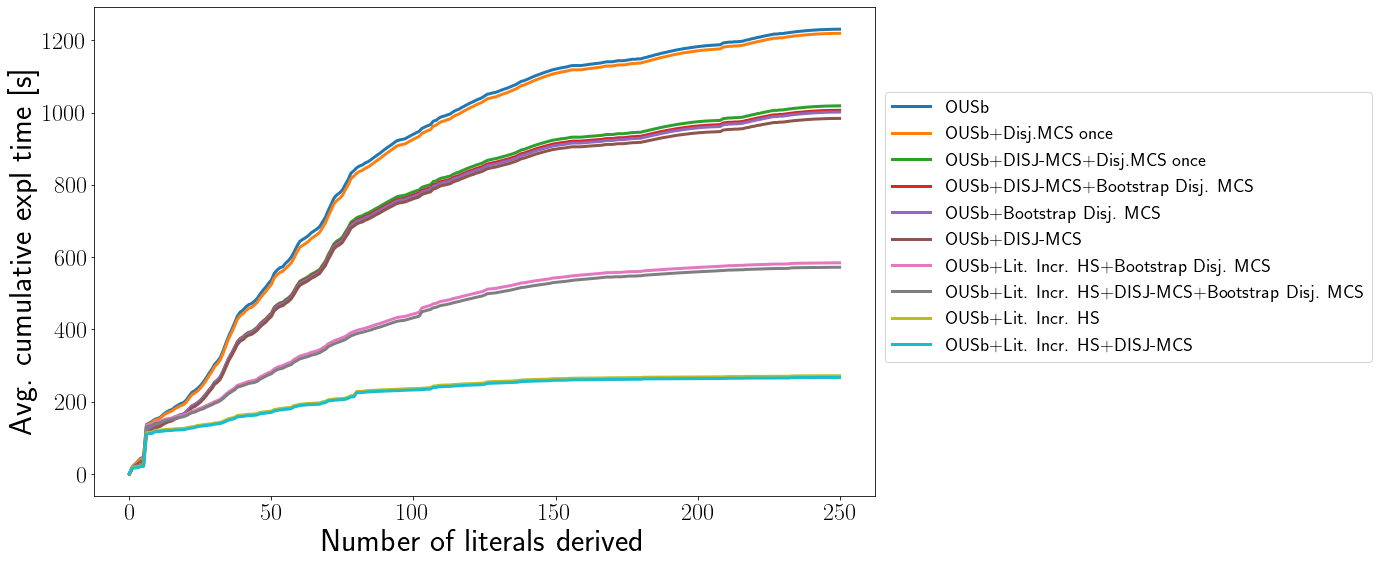

In [109]:
ousb_configs =  [config for config in set(df["params_explanation_config"]) if "OUSB" in config.upper()]
print(ousb_configs)

ignored_ousb = [
    'OUSb+Lit. Incr. HS+Disj.MCS once',
    'OUSb+Lit. Incr. HS+DISJ_MCS+Disj.MCS once',
    'OUSb+Shared SS. caching+DISJ_MCS+Bootstrap Disj. MCS',
    'OUSb+Shared SS. caching+Bootstrap Disj. MCS',
    'OUSb+Shared SS. caching+DISJ_MCS+Disj.MCS once',
    'OUSb+Shared SS. caching+DISJ_MCS',
    'OUSb+Shared SS. caching+Disj.MCS once',
    'OUSb+Shared SS. caching'
]

df_ousb_mcs_enum = df_enhanced[
    df_enhanced["params_explanation_config"].isin(ousb_configs) & 
    df_enhanced["params_instance"].isin(isntances)
]
df_ousb = df[
    df["params_explanation_config"].isin(ousb_configs)
]
df_ousb.to_excel('/home/emilio/research/OCUSExplain/meetings/2021/presentations/ousb_2.xlsx', index = False)


# display(df_ocus_mcs_enum)
d_cumul_avg_time_incr, ordering = summarize_cumalitve_lits_derived_time(df_ousb_mcs_enum, "params_explanation_config",ignored_ousb)
plot_derived_lits_avg_time(
    d_cumul_avg_time_incr, 
    ordering=ordering,
    figsize=(14, 9), 
    with_line = False,
    next_to_graph=True,
    figure_path="/home/emilio/research/OCUSExplain/meetings/2021/presentations/2021_07_22_ousb_disj_mcs_enum.pdf",
)

saving to path= /home/emilio/research/OCUSExplain/meetings/2021/presentations/2021_07_22_ous_disj_mcs_enum.pdf


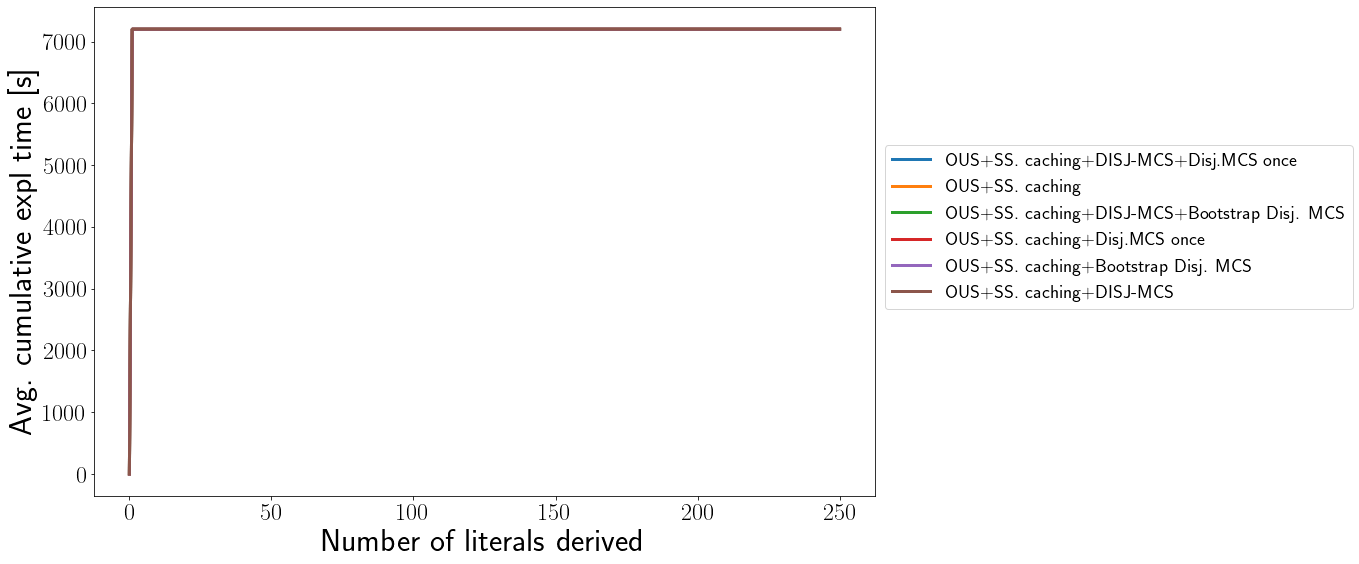

In [91]:
ous_configs =  [config for config in set(df["params_explanation_config"]) if "OUS" in config.upper() and config not in ousb_configs]

ignored_ous = []
df_ous_mcs_enum = df_enhanced[
    df_enhanced["params_explanation_config"].isin(ous_configs)& 
    df_enhanced["params_instance"].isin(isntances)
]

df_ous = df[
    df["params_explanation_config"].isin(ous_configs)
]
df_ous.to_excel('/home/emilio/research/OCUSExplain/meetings/2021/presentations/ous_2.xlsx', index = False)


# display(df_ocus_mcs_enum)
d_cumul_avg_time_incr, ordering = summarize_cumalitve_lits_derived_time(df_ous_mcs_enum, "params_explanation_config",ignored_ous)
plot_derived_lits_avg_time(
    d_cumul_avg_time_incr, 
    ordering=ordering,
    figsize=(14, 9), 
    figure_path="/home/emilio/research/OCUSExplain/meetings/2021/presentations/2021_07_22_ous_disj_mcs_enum.pdf",
    with_line = False,
    next_to_graph=True
)